In [1]:
import os 
import tensorflow as tf

# Importing matplotlib to plot images.
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
import sklearn.metrics
tf.__version__

2024-02-10 12:59:45.123588: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-10 12:59:46.220277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'2.12.1'

In [2]:
# !pip3 install git+https://github.com/pvigier/perlin-numpy
import perlin_numpy #generate_perlin_noise_2d


In [3]:
N = 28

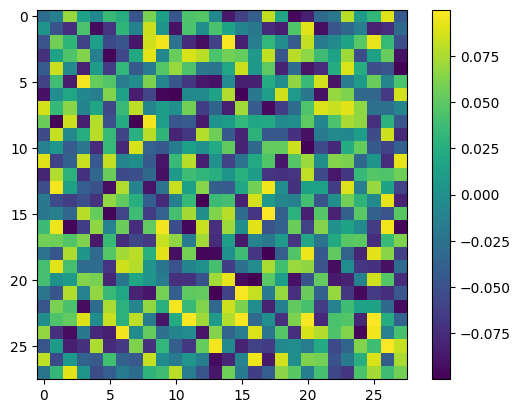

In [4]:
noiseMap  = (np.random.random((N,N))-.5) * .2
plt.imshow(noiseMap)
plt.colorbar()

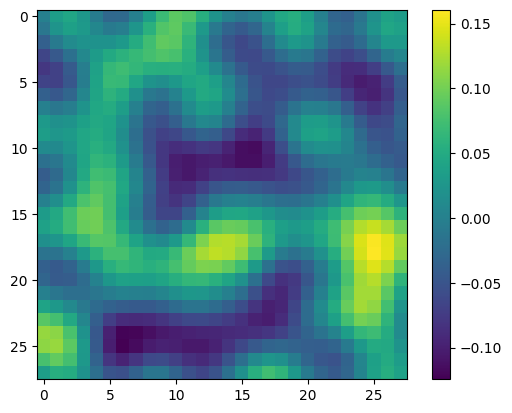

In [5]:
noiseMap  = perlin_numpy.generate_perlin_noise_2d((N, N), (4, 4)) *.2
plt.imshow(noiseMap)
plt.colorbar()

In [6]:
%%timeit
np.random.random((N,N))

6.22 µs ± 34.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [7]:
%%timeit
perlin_numpy.generate_perlin_noise_2d((N, N), (4, 4))

220 µs ± 6.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
# the data, split between train and test sets
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

In [9]:
shape = (28, 28, 1)
# reshape image data
x_train = x_train.reshape(-1, shape[0] *  shape[1] * shape[2])
x_val = x_val.reshape(-1, shape[0] *  shape[1] * shape[2])

# convert to float
x_train = x_train.astype(np.float32)
x_val = x_val.astype(np.float32)

# normalize to a scale between -1 and 1
x_train = x_train / 127.5 -1
x_val = x_val / 127.5 -1

print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')

# convert class vectors to binary class matrices (one-hot notation)
num_classes = 10
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes)

60000 train samples
10000 test samples


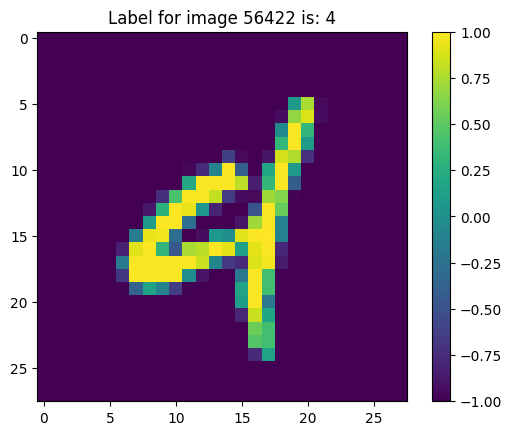

In [10]:
np.random.seed(42)
i = np.random.randint(0, len(x_train))
plt.imshow(x_train[i].reshape(shape))
plt.title("Label for image %i is: %s" % (i, y_train[i]))
plt.colorbar()

## GPU and CPU settings
If GPU is not available, comment out the bottom block.

In [11]:
if True:
    # Enter either 0 or 1 below to select the GPU to use
    os.environ["CUDA_VISIBLE_DEVICES"]="0"

    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Data Augmentation using a Generator

In [12]:
class DataGenerator:
    

    def __init__(self, dataX, dataY, batch_size = 64, shuffle = True, isTrain=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.isTrain = isTrain
        self.dataX = dataX
        self.dataY = dataY
        self.n_batches = int(np.round(len(self.dataX)/batch_size))
        self.indices = list(range(len(self.dataX)))
        
    def __call__(self, shuffle=True):
    
        if self.shuffle:
            np.random.shuffle(self.indices)

        for j in range(self.n_batches-1):
            returnX = []
            returnY = []
            
            # It would be much better to do this within the next loop, but its to slow.
            noiseMap = perlin_numpy.generate_perlin_noise_2d((28, 28), (4, 4)) *.4
            noiseMap = noiseMap.reshape(-1)
            
            for i in self.indices[j*batch_size:(j+1)*batch_size]:
                
                x = self.dataX[i]
                y = self.dataY[i]
                
                
                if self.isTrain:
                    # Data Augmentation is typically only applyed to the train set to reduce overfitting.
                    # If a test set is available it might be an idea to also use Data Augmentation for the validation set.
                    
                    ## A) One option is to do this per semple using 2D noise but as we seen this is slow.
                    #noiseMap = perlin_numpy.generate_perlin_noise_2d
                    ## B) using the same for each sampel is a cheapter option
                    x += noiseMap
                    None
                    
                #img = cv2.imread(f)
                #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                #if not((img.shape[0] == self.res[0]) & (img.shape[1] == self.res[1])):
                #    img = cv2.resize(img, (self.res[1], self.res[0]))

                # Shift Blob (img_A) and Template (img_B) using normal distribution
                # stdev = 1 -> 99.73% samples within range +- 3 around mean = 0
                #for shift_axis in [0, 1]:
                #    shift_amount = np.random.randint(-1,2)
                #    img_A = np.roll(img_A, shift_amount, axis = shift_axis)
                #    img_B = np.roll(img_B, shift_amount*4, axis = shift_axis)

                returnX.append(x)
                returnY.append(y)

            # We did this in the pre processing, could also be done here. 
            #returnX = np.array(returnX)/127.5 - 1. 
            
            if self.isTrain:
                if False:
                    noiseMap = perlin_numpy.generate_perlin_noise_3d((len(returnX), 28, 28), (4, 4, 4))
                    noiseMap = noiseMap.reshape(len(returnX), -1)
                    returnX = np.array(returnX)
                    returnX += noiseMap
                    #returnX[returnX<-1] = -1
                    #returnX[returnX>1] = 1

            yield returnX, returnY

In [13]:
batch_size = 32

gen_train = DataGenerator(x_train, y_train_one_hot, batch_size=batch_size)
gen_val = DataGenerator(x_val, y_val_one_hot, batch_size=batch_size, isTrain=False)

train_dataset = tf.data.Dataset.from_generator(gen_train, 
                                         output_signature=(
                                             tf.TensorSpec(shape=(batch_size, shape[0] *  shape[1] * shape[2]), dtype=tf.float32),
         tf.TensorSpec(shape=(batch_size, 10), dtype=tf.float32)
         )).prefetch(tf.data.AUTOTUNE).cache().repeat()

val_dataset = tf.data.Dataset.from_generator(gen_val, 
                                         output_signature=(
                                             tf.TensorSpec(shape=(batch_size, shape[0] *  shape[1] * shape[2]), dtype=tf.float32),
         tf.TensorSpec(shape=(batch_size, 10), dtype=tf.float32))).prefetch(tf.data.AUTOTUNE).cache().repeat()

2024-02-10 12:59:56.227279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29458 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0


2024-02-10 12:59:56.904485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-10 12:59:56.904685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-10 12:59:56.952300: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().ta

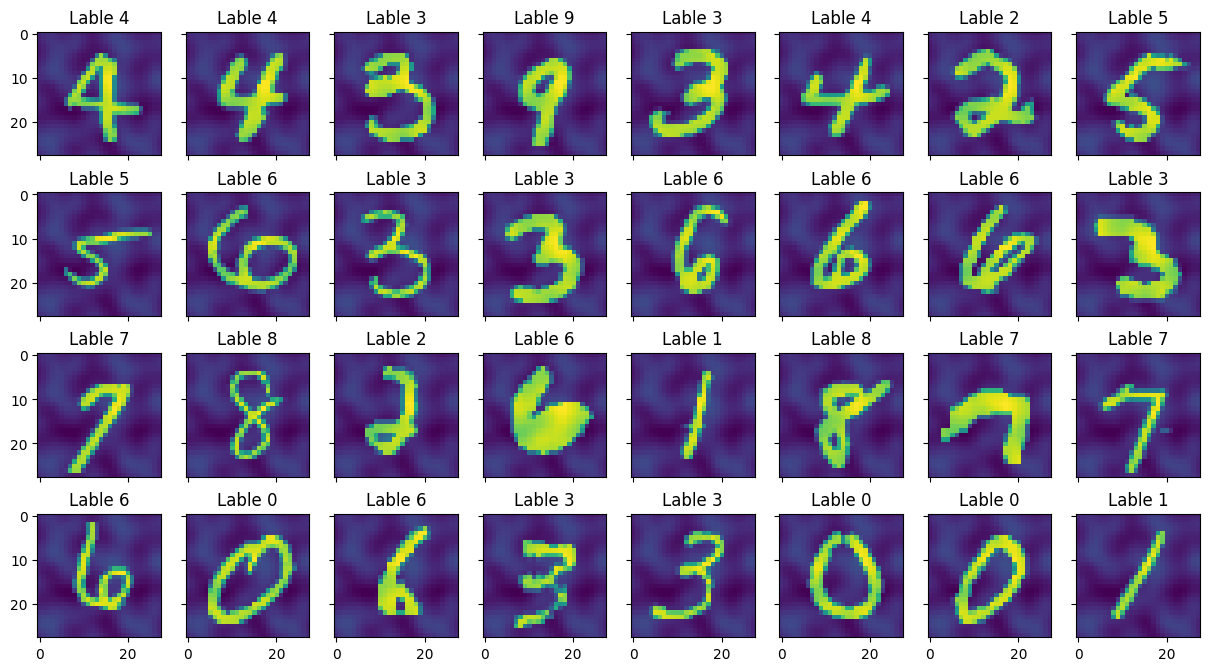

In [14]:
imagesPerRow = 8
columns = batch_size // imagesPerRow

fig, ax = plt.subplots(columns, imagesPerRow, figsize=(15,8), sharex=True, sharey=True)
ax = ax.flatten()
for elem in train_dataset.take(1):
    
    dataXFromGenerator = elem[0].numpy()
    dataYFromGenerator = elem[1].numpy()
    for i in range (dataXFromGenerator.shape[0]):
        ax[i].imshow(dataXFromGenerator[i].reshape(shape))
        ax[i].set_title(f"Lable {np.argmax(dataYFromGenerator[i])}")


In [15]:
########## HYPER PARAMETERS
#batch_size = 128 is specified when setting up the generator
epochs = 2
optimizer = tf.keras.optimizers.Adam()
########## HYPER PARAMETERS

########## MODEL ARCHITECTURE
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(None, shape[0] *  shape[1] * shape[2]), name="input"))
model.add(tf.keras.layers.Reshape((shape[0], shape[1], shape[2])))
model.add(tf.keras.layers.Conv2D(5, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.Dense(5, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
########## MODEL ARCHITECTURE

# Print summary
model.summary()

# compile model for training
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    steps_per_epoch=len(x_train),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_dataset,
                    validation_steps=len(x_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 5)         50        
                                                                 
 flatten (Flatten)           (None, 3380)              0         
                                                                 
 dense (Dense)               (None, 10)                33810     
                                                                 
Total params: 33,860
Trainable params: 33,860
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2


2024-02-10 13:00:00.280414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-10 13:00:00.280588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-10 13:00:00.899864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-02-10 13:00:01.145774: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f2719506280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-10 13:00:01.145807: I tensorf

59994/60000 [============================>.] - ETA: 0s - loss: 0.0364 - accuracy: 0.9894

2024-02-10 13:04:52.536409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-10 13:04:52.536925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60000/60000 [==============================] - 322s 5ms/step - loss: 0.0364 - accuracy: 0.9894 - val_loss: 0.2079 - val_accuracy: 0.9703
Epoch 2/2
60000/60000 [==============================] - 320s 5ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.2696 - val_accuracy: 0.9707


# Plot training and test accuracy

In [16]:
# use model for inference to get test accuracy
y_val_pred = model.predict(x_val)
y_val_pred = np.argmax(y_val_pred, axis=1)

print ('\n Summary of the precision, recall, F1 score for each class:')
print (sklearn.metrics.classification_report(y_val, y_val_pred))

print ('\n Confusion matrix: ')
print (sklearn.metrics.confusion_matrix(y_val, y_val_pred))

313/313 [==============================] - 1s 2ms/step

 Summary of the precision, recall, F1 score for each class:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.95      0.99      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.99      0.94      0.97       892
           6       0.96      0.98      0.97       958
           7       0.96      0.97      0.96      1028
           8       0.95      0.97      0.96       974
           9       0.98      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


 Confusion matrix: 
[[ 962    0    4    0    1    2    5    2    4    0]
 [   0 1124    2    1    1    0    3    2    2    0

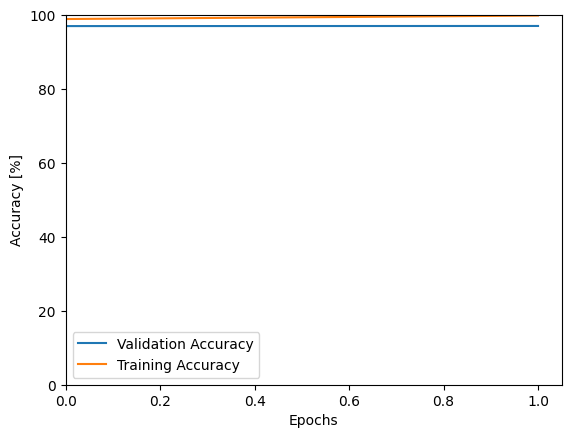

In [17]:
plt.plot(np.array(history.history['val_accuracy'])*100, label="Validation Accuracy")
plt.plot(np.array(history.history['accuracy'])*100, label="Training Accuracy")
plt.ylabel("Accuracy [%]")
plt.xlabel("Epochs")
plt.ylim(0,100)
plt.xlim(0,)
plt.legend()

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

2024-02-10 13:10:43.765308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input' with dtype float and shape [?,?,784]
	 [[{{node input}}]]
2024-02-10 13:10:43.813687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'input' with dtype float and shape [?,?,784]
	 [[{{node input}}]]
2024-02-10 13:10:43.831245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,784]
	 [[{{node inputs}}]]
2024-02-10 13:

INFO:tensorflow:Assets written to: /tmp/tmp2kqd4i_i/assets


INFO:tensorflow:Assets written to: /tmp/tmp2kqd4i_i/assets
2024-02-10 13:10:45.294084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_input' with dtype float and shape [?,?,784]
	 [[{{node serving_default_input}}]]
2024-02-10 13:10:46.055189: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-02-10 13:10:46.055223: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-02-10 13:10:46.055682: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2kqd4i_i
2024-02-10 13:10:46.056971: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-02-10 13:10:46.056988: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (